In [22]:
## importing libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [23]:
## transformations
# normalization values (ImageNet stats)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for faster training (adjust if needed), 224*224 faster, 384*384 better accuracy, 256*256 if run into mem errors
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), # Simulates lighting variations
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)), # Helps focus on smaller regions
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [24]:
## Loading the datasets
# Set paths relative to notebook location
data_dir = "data"

train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transform)

# Check the mapping of class name → label index
print("Class to index mapping:")
print(train_dataset.class_to_idx) #for decoding predictions

Class to index mapping:
{'dislike': 0, 'fist': 1, 'like': 2, 'ok': 3, 'palm': 4, 'rock': 5}


In [25]:
## Creating dataloaders
batch_size = 32  # I will also experiment with 64, 16, and 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### Architecture

This architecture has:
* 3 convolutional blocks with increasing depth
* Dropout before the classifier to reduce overfitting
* Final fully connected layer with 6 outputs (1 per gesture class)

In [ ]:
## Defining the model

import torch.nn as nn
import torch.nn.functional as F

class HandGestureCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(HandGestureCNN, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #in_channels, out_channels, kernel_size, -OPTIONALS-> stride, padding, dilation, groups, bias, padding_mode='zeroes'
            nn.BatchNorm2d(32),                         # in
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Assuming input size is 224x224 → after 3 pools (divided by 8) = 28x28
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 28 * 28, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)

## Model features

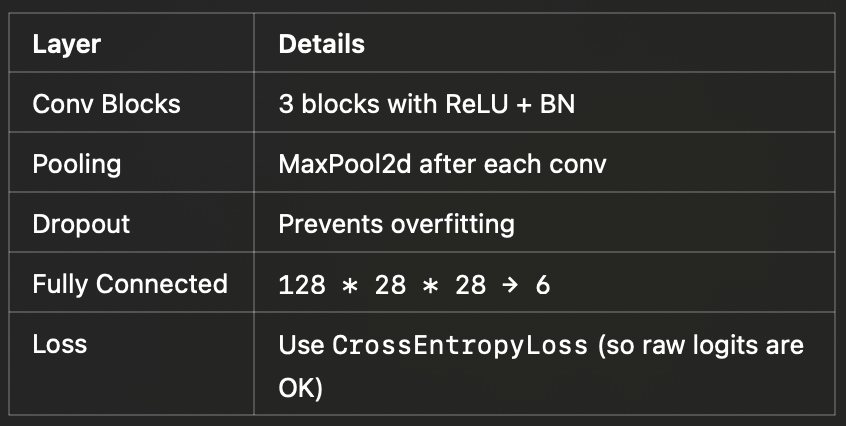

In [27]:
## Model Instantiation and MPS GPU Device Setup

import torch
from torch import nn

# Device setup: MPS (for Mac), fallback to CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate your model
model = HandGestureCNN(num_classes=6).to(device)

Using device: mps


In [ ]:
## Defining the Optimizer and Loss Function

import torch.optim as optim

# Loss function for multi-class classification
#Label smoothing to cross entropy below #criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 0.1 is a good starting point, helps prevent overconfidence

# Adam optimizer with optional weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [41]:
criterion = nn.CrossEntropyLoss() 

In [36]:
## defining scheduler after optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
#This reduces LR by half if val loss doesn’t improve after 2 epochs.

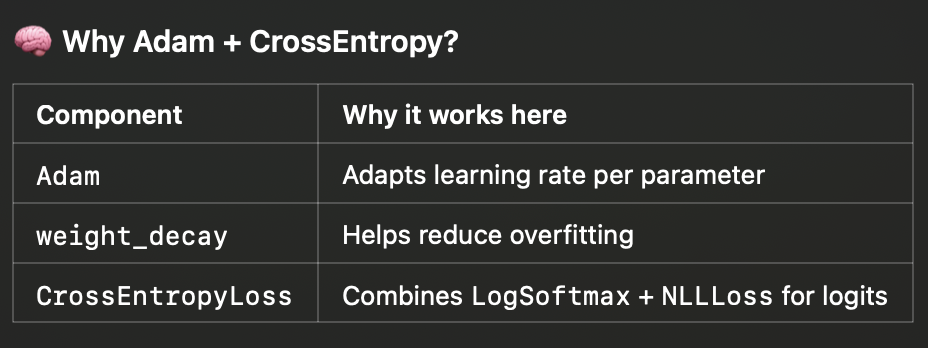

In [37]:
## TRAINING LOOP !!! Includes: 
    # Process tracking for training and validation, 
    # Saving the best model to checkpoints/best_model.pth
    # Support both MPS or CPU

import time

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    no_improve_epochs = 0 #logic to automatically stop when overfitting while not watching the training, patience defaulted to 3
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        #  Evaluate on validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        #  Save best model & check early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            no_improve_epochs = 0

            torch.save({
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict()
            }, 'checkpoints/full_checkpoint.pth')

            torch.save(model.state_dict(), "checkpoints/best_model.pth")
            print(f"✅ Saved new best model at epoch {epoch+1}")

        else:
            no_improve_epochs += 1
            print(f"⏳ No improvement for {no_improve_epochs} epoch(s)")

        #  Print epoch summary
        duration = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {epoch_val_acc*100:.2f}% | "
              f"Time: {duration:.1f}s")
        
        scheduler.step(epoch_val_loss)## step the learning rate rescheduler
#
        if no_improve_epochs >= patience:
            print(f"🛑 Early stopping triggered after {epoch+1} epochs.")
            print(f" Best model was at val loss: {best_val_loss:.4f}")
            break

    return history



### Training the Model

In [38]:
num_epochs = 20  # todo: mess around with different number of epochs
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

✅ Saved new best model at epoch 1
Epoch 1/20 | Train Loss: 1.0821 | Val Loss: 0.8947 | Val Acc: 83.19% | Time: 162.6s
✅ Saved new best model at epoch 2
Epoch 2/20 | Train Loss: 1.0805 | Val Loss: 0.8808 | Val Acc: 83.23% | Time: 161.7s
⏳ No improvement for 1 epoch(s)
Epoch 3/20 | Train Loss: 1.0792 | Val Loss: 0.8918 | Val Acc: 82.89% | Time: 159.5s
✅ Saved new best model at epoch 4
Epoch 4/20 | Train Loss: 1.0766 | Val Loss: 0.8757 | Val Acc: 83.14% | Time: 161.4s
⏳ No improvement for 1 epoch(s)
Epoch 5/20 | Train Loss: 1.0725 | Val Loss: 0.8771 | Val Acc: 83.39% | Time: 161.3s
⏳ No improvement for 2 epoch(s)
Epoch 6/20 | Train Loss: 1.0698 | Val Loss: 0.8762 | Val Acc: 83.73% | Time: 159.7s
⏳ No improvement for 3 epoch(s)
Epoch 7/20 | Train Loss: 1.0697 | Val Loss: 0.8851 | Val Acc: 81.93% | Time: 158.9s
🛑 Early stopping triggered after 7 epochs.
 Best model was at val loss: 0.8757


#### Notes:
*	log history to CSV or plot it later
*	resume training from best_model.pth if needed

## Side Quest: 
### A) Save training History to CSV

In [45]:
## Save to CSV

import pandas as pd

# Convert training history to DataFrame
df_history = pd.DataFrame(history)
df_history.to_csv("checkpoints/training_history.csv", index=False)

print("Training history saved to checkpoints/training_history.csv") #Saves epoch-wise values for: train_loss, val_loss, val_acc

Training history saved to checkpoints/training_history.csv


### B) Plot Training Curves: n epochs

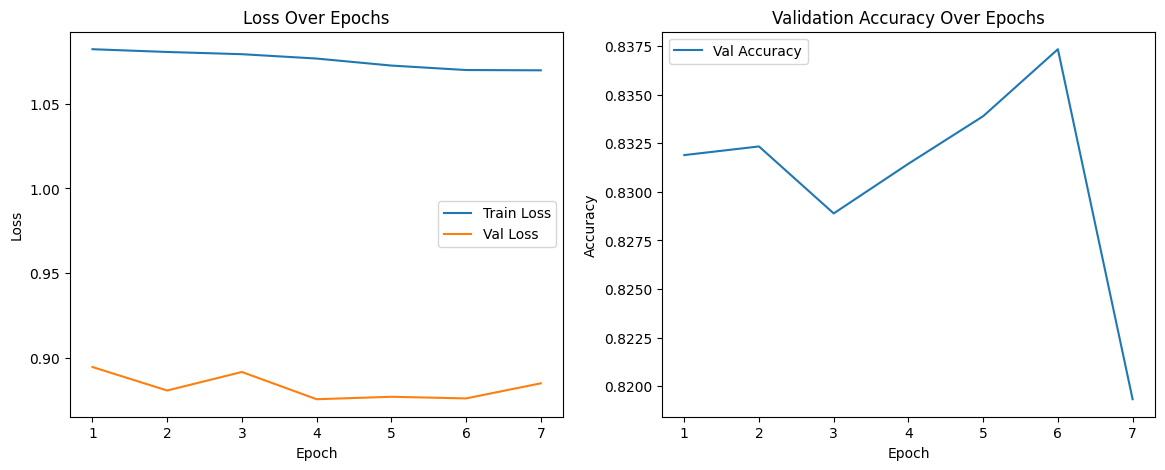

In [46]:
## Plot Loss & Accuracy

import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['val_acc'], label='Val Accuracy')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### C) Resume Training from Best Model and Optimizer state (Weights and optimizer's internal state)

In [43]:
## To reload and train from the best model

# Re-initialize the model and optimizer first
model = HandGestureCNN(num_classes=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Load saved weights and model steps (full checkpoint)
checkpoint = torch.load("checkpoints/full_checkpoint_v2.pth", map_location=device)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])

print("Model weights and optimizer state loaded. Ready to resume training.")

Model weights and optimizer state loaded. Ready to resume training.


In [44]:
## Then Continue training by running this:
history2 = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

✅ Saved new best model at epoch 1
Epoch 1/10 | Train Loss: 0.8250 | Val Loss: 0.5343 | Val Acc: 82.88% | Time: 171.7s
✅ Saved new best model at epoch 2
Epoch 2/10 | Train Loss: 0.8158 | Val Loss: 0.5185 | Val Acc: 82.84% | Time: 171.1s
⏳ No improvement for 1 epoch(s)
Epoch 3/10 | Train Loss: 0.8143 | Val Loss: 0.5335 | Val Acc: 82.63% | Time: 171.8s
⏳ No improvement for 2 epoch(s)
Epoch 4/10 | Train Loss: 0.8114 | Val Loss: 0.5228 | Val Acc: 83.31% | Time: 173.4s
⏳ No improvement for 3 epoch(s)
Epoch 5/10 | Train Loss: 0.8055 | Val Loss: 0.5249 | Val Acc: 83.78% | Time: 174.2s
🛑 Early stopping triggered after 5 epochs.
 Best model was at val loss: 0.5185


### Training Complete----

--------------------------------------------------------------------------------------------

### Test Set Evaluation
* load best model
* evaluate it on test_loader
* compute final loss and accuracy
* Optionally view per-class stats or a confusion matrix

In [48]:
## Loading the best model

# Re-initialize model
model = HandGestureCNN(num_classes=6).to(device)

# Load best weights (inference only — no optimizer needed)
model.load_state_dict(torch.load("checkpoints/best_model_v2.pth", map_location=device))

model.eval()
print("Best model loaded for test evaluation.")

Best model loaded for test evaluation.


In [49]:
## Run Evaluation on test set

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / total
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.5364
Test Accuracy: 82.28%


14	Write prediction/inference function that maps logits → class name

### Plotting a confusion matrix

In [53]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [54]:
## Get all the predictions and labels

# Make sure model is in eval mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

<Figure size 800x600 with 0 Axes>

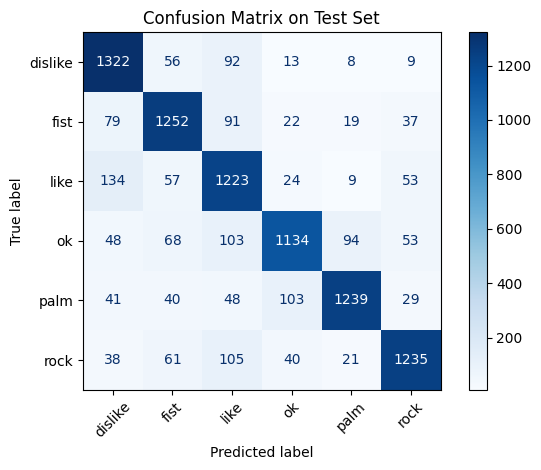

In [55]:
## plot the confussion matrix

# Use the mapping from ImageFolder
class_names = test_dataset.classes  # Same order as class_to_idx

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

### To export the model